In [1]:
import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

In [5]:
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]


In [6]:
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

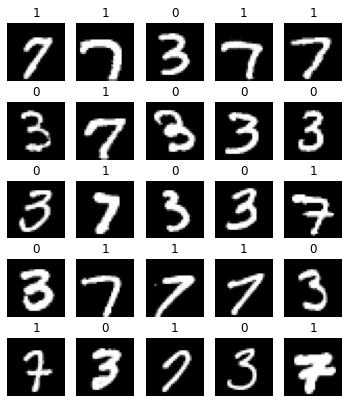

In [8]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')
plt.show()


In [9]:
def getInitialParameters(layerDims):
    parameters = {}
    N = len(layerDims)

    for l in range(1, N):
        parameters['W' + str(l)] = np.random.randn(layerDims[l], layerDims[l-1]) * 0.01
        parameters['b' + str(l)] =  np.zeros((layerDims[l], 1))
        
    return parameters

def linearForward(A, W, b):    
    Z = np.dot(W, A) + b
    cache = (A, W, b)    
    return Z, cache

def forwardActivation(APrev, W, b, activationName):
    Z, linear_cache  = linearForward(APrev, W, b)
    activation_cache = Z

    if activationName == "sigmoid":
        A = 1/(1+np.exp(-Z))
    
    elif activationName == "relu":
        A = np.maximum(0,Z)

    cache = (linear_cache, activation_cache)

    return A, cache

def forward(X, parameters):
    caches = []
    A = X
    N = len(parameters) // 2 
            
    for l in range(1, N):
        A_prev = A 
        A, cache = forwardActivation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activationName = "relu")
        caches.append(cache)
        
    AL, cache = forwardActivation(A, parameters['W' + str(N)], parameters['b' + str(N)], activationName = "sigmoid")
    caches.append(cache)
            
    return AL, caches

def getCost(AL, Y):    
    m = Y.shape[1]
    logprobs = np.multiply(np.log(AL),Y) +  np.multiply(np.log(1-AL), (1-Y))
    cost = -1/m*np.sum(logprobs)
    cost = np.squeeze(cost)     
    return cost

In [10]:
def linearBackward(dZ, cache):
    APrev, w, b = cache
    m = APrev.shape[1]

    dW = 1./m*np.dot(dZ, APrev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(w.T, dZ)
    
    return dA_prev, dW, db

def activationBackward(dA, cache, activationName):
    linear_cache, activation_cache = cache
    
    if activationName == "relu":
        dZ = np.array(dA, copy=True)
        dZ[activation_cache <= 0] = 0
        
    elif activationName == "sigmoid":
        s = 1/(1+np.exp(-activation_cache))
        dZ = dA * s * (1-s)

    dA_prev, dW, db = linearBackward(dZ, linear_cache)
    
    return dA_prev, dW, db


In [11]:
def backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = activationBackward(dAL, current_cache, activationName = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activationBackward(grads["dA" + str(l + 2)],  current_cache, activationName = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def updateParameters(parameters, grads, learningRate):    
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learningRate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learningRate * grads["db" + str(l + 1)]        
    return parameters

In [12]:
learning_rate = 0.01
epochs = 10

losses = []
parameters = getInitialParameters([784, 128, 100, 1])

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    tmpLosses = []
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy().T
        y = np.expand_dims(y.numpy(), 1).T

        al, cache = forward(x, parameters)
        tmpLosses.append(getCost(al, y))
        grads = backward(al, y, cache)
        parameters = updateParameters(parameters, grads, learning_rate)

    losses.append(np.mean(tmpLosses))


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


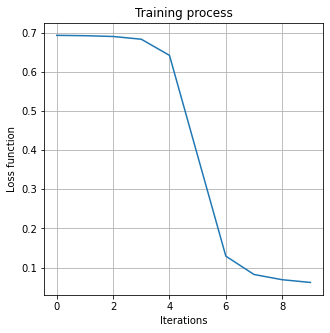

In [13]:

plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.show()